In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sn
import time
import tensorflow_datasets as tfds
import json
import scipy.io
import os
import cv2

In [3]:
data = scipy.io.loadmat('/content/drive/MyDrive/DL - HW2 Practical/joints')['joints']
images_filenames = os.listdir('/content/drive/MyDrive/DL - HW2 Practical/images')
images_filenames.sort()
scaled_images = []
i = 0
for file_name in images_filenames:
  path = '/content/drive/MyDrive/DL - HW2 Practical/images/' + file_name
  image = plt.imread(path)
  scaled_images.append(cv2.resize(image, (220, 220)))
  scale = 220/np.array([image.shape[1], image.shape[0]])
  data[0:2, :, i] = np.multiply(data[0:2, :, i].T, scale).T
  i = i + 1
scaled_images = np.array(scaled_images)

In [4]:
train_and_validation_images = scaled_images[0:1700]
train_and_validation_data = data[:, :, 0:1700]
test_images = scaled_images[1700:2000]
test_data = data[:, :, 1700:2000]
random_number = np.random.randint(1e9)
np.random.seed(random_number)
permutation = np.random.choice(range(train_and_validation_images.shape[0]), train_and_validation_images.shape[0], False)
train_and_validation_images = train_and_validation_images[permutation]
train_and_validation_data = train_and_validation_data[:, :, permutation]
train_images = train_and_validation_images[0:1400]
train_data = train_and_validation_data[:, :, 0:1400]
validation_images = train_and_validation_images[1400:1700]
validation_data = train_and_validation_data[:, :, 1400:1700]

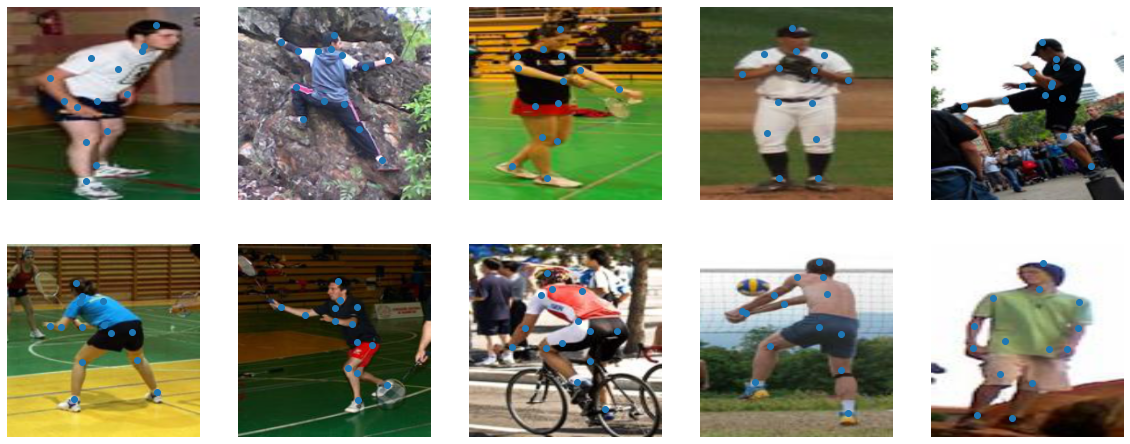

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
for i in range(10):
  random_number = np.random.randint(1400)
  image = train_images[random_number]
  ax[i//5, i%5].imshow(image)
  ax[i//5, i%5].scatter(train_data[0, :, random_number].T, train_data[1, :, random_number].T)
  ax[i//5, i%5].axis('off')

In [6]:
normalized_train_images = (train_images - np.mean(train_images, axis=0)) / (1e-3 + np.sqrt(np.var(train_images, axis=0)))
normalized_validation_images = (validation_images- np.mean(validation_images, axis=0)) / (1e-3 + np.sqrt(np.var(validation_images, axis=0)))
normalized_test_images = (test_images - np.mean(test_images, axis=0)) / (1e-3 + np.sqrt(np.var(test_images, axis=0)))

In [7]:
tf.config.run_functions_eagerly(True)

In [8]:
input_shape = (220, 220, 3)
Conv_layer_1_size = 96
Conv_layer_2_size = 256
Conv_layer_3_size = 384
Conv_layer_4_size = 384
Conv_layer_5_size = 256
FC_layer_1_size = 4096
FC_layer_2_size = 4096
output_size = 28
batch_size = 50
number_of_epochs = 50

In [14]:
model=tf.keras.models.Sequential(name='Pose_estimation')
model.add(tf.keras.layers.Input(shape=input_shape, name='input'))
model.add(tf.keras.layers.Conv2D(Conv_layer_1_size, (11, 11), strides=(4, 4), padding='same', activation='relu', name='con_layer_1'))
model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization, name='lambda_1'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(Conv_layer_2_size, (5, 5), strides=(1, 1), padding='same', activation='relu', name='con_layer_2'))
model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization, name='lambda_2'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(Conv_layer_3_size, (3, 3), strides=(1, 1), padding='same', activation='relu', name='con_layer_3'))
model.add(tf.keras.layers.Conv2D(Conv_layer_4_size, (3, 3), strides=(1, 1), padding='same', activation='relu', name='con_layer_4'))
model.add(tf.keras.layers.Conv2D(Conv_layer_5_size, (3, 3), strides=(1, 1), padding='same', activation='relu', name='con_layer_5'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten(name='flatten'))
model.add(tf.keras.layers.Dense(FC_layer_1_size, activation='relu', name='hidden_layer_1'))
model.add(tf.keras.layers.Dense(FC_layer_2_size, activation='relu', name='hidden_layer_2'))
model.add(tf.keras.layers.Dense(output_size, activation='linear', name='output'))
print(model.summary())

Model: "Pose_estimation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 con_layer_1 (Conv2D)        (None, 55, 55, 96)        34944     
                                                                 
 lambda_1 (Lambda)           (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 con_layer_2 (Conv2D)        (None, 27, 27, 256)       614656    
                                                                 
 lambda_2 (Lambda)           (None, 27, 27, 256)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                               

In [15]:
def limb_length(joints_locations):
  joints_locations = joints_locations.numpy()
  limb_length = []
  temp1 = np.sqrt(np.power(joints_locations[:, 0]-joints_locations[:, 1], 2)+np.power(joints_locations[:, 14]-joints_locations[:, 15], 2))
  limb_length.append(temp1)
  temp2 = np.sqrt(np.power(joints_locations[:, 1]-joints_locations[:, 2], 2)+np.power(joints_locations[:, 15]-joints_locations[:, 16], 2))
  limb_length.append(np.minimum(temp1, temp2))
  limb_length.append(temp2)
  temp1 = np.sqrt(np.power(joints_locations[:, 3]-joints_locations[:, 4], 2)+np.power(joints_locations[:, 17]-joints_locations[:, 18], 2))
  limb_length.append(temp1)
  temp2 = np.sqrt(np.power(joints_locations[:, 4]-joints_locations[:, 5], 2)+np.power(joints_locations[:, 18]-joints_locations[:, 19], 2))
  limb_length.append(np.minimum(temp1, temp2))
  limb_length.append(temp2)
  temp1 = np.sqrt(np.power(joints_locations[:, 6]-joints_locations[:, 7], 2)+np.power(joints_locations[:, 20]-joints_locations[:, 21], 2))
  limb_length.append(temp1)
  temp2 = np.sqrt(np.power(joints_locations[:, 7]-joints_locations[:, 8], 2)+np.power(joints_locations[:, 21]-joints_locations[:, 22], 2))
  limb_length.append(np.minimum(temp1, temp2))
  limb_length.append(temp2)
  temp1 = np.sqrt(np.power(joints_locations[:, 9]-joints_locations[:, 10], 2)+np.power(joints_locations[:, 23]-joints_locations[:, 24], 2))
  limb_length.append(temp1)
  temp2 = np.sqrt(np.power(joints_locations[:, 10]-joints_locations[:, 11], 2)+np.power(joints_locations[:, 24]-joints_locations[:, 25], 2))
  limb_length.append(np.minimum(temp1, temp2))
  limb_length.append(temp2)
  temp1 = temp1 = np.sqrt(np.power(joints_locations[:, 12]-joints_locations[:, 13], 2)+np.power(joints_locations[:, 26]-joints_locations[:, 27], 2))
  limb_length.append(temp1)
  limb_length.append(temp1)
  limb_length = np.array(limb_length)
  return limb_length.T
class PCP(tf.keras.metrics.Metric):
  def init(self, **kwargs):
    super(PCP, self).init(**kwargs)
  def update_state(self, y_true, y_pred, sample_weight=None):
    self.limb_length = limb_length(y_true)/2
    self.distance = np.sqrt(np.power(y_true[:, 0:14]-y_pred[:, 0:14], 2)+np.power(y_true[:, 14:28]-y_pred[:, 14:28], 2))
  def result(self):
    return np.mean(np.where(self.distance <= self.limb_length, 1, 0))
  def reset_state(self):
    self.limb_length = None
    self.distance = None
class PDJ(tf.keras.metrics.Metric):
  def init(self, **kwargs):
    super(PDJ, self).init(**kwargs)
  def update_state(self, y_true, y_pred, sample_weight=None):
    self.torso_diameter = np.sqrt(np.power(y_true[:, 2]-y_true[:, 9], 2)+np.power(y_true[:, 2]-y_true[:, 9], 2))
    self.distance = np.sqrt(np.power(y_true[:, 0:14]-y_pred[:, 0:14], 2)+np.power(y_true[:, 14:28]-y_pred[:, 14:28], 2))
  def result(self):
    return np.mean(np.where(self.distance <= np.repeat(self.torso_diameter, 14).reshape([-1, 14]), 1, 0))
  def reset_state(self):
    self.limb_length = None
    self.distance = None
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss, metrics=[PCP(name='PCP'), PDJ(name='PDJ')])

In [16]:
def scheduler(epoch, lr):
  return lr/1.1
lr_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(normalized_train_images, np.concatenate((train_data[0, :, :], train_data[1, :, :])).T, batch_size=batch_size, epochs=number_of_epochs, callbacks=[lr_cb], validation_data=(normalized_validation_images, np.concatenate((validation_data[0, :, :], validation_data[1, :, :])).T))
model.save('./drive/MyDrive/DL - HW2 Practical/models/Pose_estimation')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/50
28/28 [==============================] - 14s 498ms/step - loss: 1321485603962880.0000 - PCP: 0.1843 - PDJ: 0.7157 - val_loss: 1934.5492 - val_PCP: 0.1343 - val_PDJ: 0.6671 - lr: 0.0182
Epoch 2/50
28/28 [==============================] - 14s 493ms/step - loss: 1134.5999 - PCP: 0.2057 - PDJ: 0.5871 - val_loss: 1068.8214 - val_PCP: 0.2300 - val_PDJ: 0.7857 - lr: 0.0165
Epoch 3/50
28/28 [==============================] - 14s 490ms/step - loss: 1000.0889 - PCP: 0.2057 - PDJ: 0.7200 - val_loss: 1081.9065 - val_PCP: 0.1900 - val_PDJ: 0.7829 - lr: 0.0150
Epoch 4/50
28/28 [==============================] - 14s 485ms/step - loss: 998.4380 - PCP: 0.2243 - PDJ: 0.6643 - val_loss: 1075.9998 - val_PCP: 0.2243 - val_PDJ: 0.7743 - lr: 0.0137
Epoch 5/50
28/28 [==============================] - 14s 486ms/step - loss: 996.0970 - PCP: 0.2171 - PDJ: 0.7543 - val_loss: 1078.4316 - val_PCP: 0.2171 - val_PDJ: 0.7914 - lr: 0.0124
Epoch 6/50
28/28 [==============================] - 14s 486ms/step - l

In [17]:
hist_df = pd.DataFrame(history.history)
with open('./drive/MyDrive/DL - HW2 Practical/models/Pose_estimation/history.csv', mode='w') as f:
    hist_df.to_csv(f)

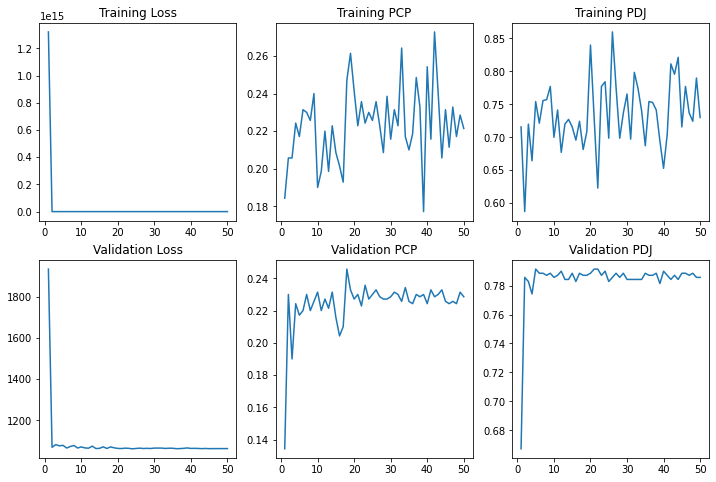

In [18]:
history = pd.read_csv('./drive/MyDrive/DL - HW2 Practical/models/Pose_estimation/history.csv')
plt.rcParams['figure.figsize'] = [12, 8]
fig = plt.figure()
ax = fig.add_subplot(2, 3, 1)
ax.set_title('Training Loss')
plt.plot(range(1, 51), history['loss'])
ax = fig.add_subplot(2, 3, 2)
ax.set_title('Training PCP')
plt.plot(range(1, 51), history['PCP'])
ax = fig.add_subplot(2, 3, 3)
ax.set_title('Training PDJ')
plt.plot(range(1, 51), history['PDJ'])
ax = fig.add_subplot(2, 3, 4)
ax.set_title('Validation Loss')
plt.plot(range(1, 51), history['val_loss'])
ax = fig.add_subplot(2, 3, 5)
ax.set_title('Validation PCP')
plt.plot(range(1, 51), history['val_PCP'])
ax = fig.add_subplot(2, 3, 6)
ax.set_title('Validation PDJ')
plt.plot(range(1, 51), history['val_PDJ'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 4s 4s/step - loss: 1031.1783 - PCP: 0.2117 - PDJ: 0.6962
Test Loss =  1031.1783447265625
Test PCP =  0.21166666666666667
Test PDJ =  0.6961904761904761


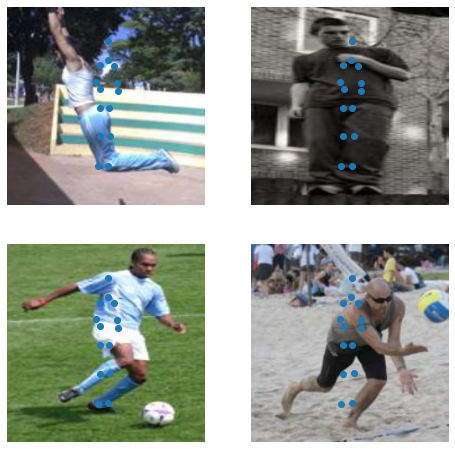

In [19]:
class PCP(tf.keras.metrics.Metric):
  def init(self, **kwargs):
    super(PCP, self).init(**kwargs)
  def update_state(self, y_true, y_pred, sample_weight=None):
    self.limb_length = limb_length(y_true)/2
    self.distance = np.sqrt(np.power(y_true[:, 0:14]-y_pred[:, 0:14], 2)+np.power(y_true[:, 14:28]-y_pred[:, 14:28], 2))
  def result(self):
    return np.mean(np.where(self.distance <= self.limb_length, 1, 0))
  def reset_state(self):
    self.limb_length = None
    self.distance = None
class PDJ(tf.keras.metrics.Metric):
  def init(self, **kwargs):
    super(PDJ, self).init(**kwargs)
  def update_state(self, y_true, y_pred, sample_weight=None):
    self.torso_diameter = np.sqrt(np.power(y_true[:, 2]-y_true[:, 9], 2)+np.power(y_true[:, 2]-y_true[:, 9], 2))
    self.distance = np.sqrt(np.power(y_true[:, 0:14]-y_pred[:, 0:14], 2)+np.power(y_true[:, 14:28]-y_pred[:, 14:28], 2))
  def result(self):
    return np.mean(np.where(self.distance <= np.repeat(self.torso_diameter, 14).reshape([-1, 14]), 1, 0))
  def reset_state(self):
    self.limb_length = None
    self.distance = None
model = tf.keras.models.load_model('./drive/MyDrive/DL - HW2 Practical/models/Pose_estimation', custom_objects={'PCP': PCP, 'PDJ': PDJ})
[test_loss, test_PCP, test_PDJ] = model.evaluate(normalized_test_images, np.concatenate((test_data[0, :, :], test_data[1, :, :])).T, batch_size=len(normalized_test_images))
print('Test Loss = ', test_loss)
print('Test PCP = ', test_PCP)
print('Test PDJ = ', test_PDJ)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
for i in range(4):
  random_number = np.random.randint(300)
  predicted_joints_locations = model.predict(normalized_test_images[random_number][np.newaxis, ...], batch_size=1)
  ax[i//2, i%2].imshow(test_images[random_number])
  ax[i//2, i%2].scatter(predicted_joints_locations[0][0:14].T, predicted_joints_locations[0][14:28].T)
  ax[i//2, i%2].axis('off')